# ECE 499/590 Final Project
## Team 13 - Mark E. McDermott, Jose A. Velasquez-Principe

---
Imports used for rest of project code

In [95]:
import pymongo
import IPython.display as ipd
import pydub
import io
import requests
import time

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.sql import Row
from pyspark.sql.types import BooleanType, ArrayType, DoubleType

---
# Part 1
## Functions

In [103]:
# This function is annotated with 'udf' and a return type which tell Spark the information
# it needs to know in order to run it. The arguments: 'file_url', 'filter_edges', and
# 'filter_amplitudes' all correspond to columns in the DataFrame. This is what allows
# Spark to call this function in parallel on each row in the DataFrame.

# This function first downloads the full MP3 file from xeno-canto. Because this is
# being done in the Spark context it is less wasteful. The alternative would have been
# to download the file in the local Python environment and then load it into the Spark
# DataFrame, thus doing extra transfers of memory.

# After loading the file, the samples are filtered using a DSP filter defined by
# the 'filter_edges' and 'filter_amplitudes' entries of each row. The filter is
# designed using Scipy's REMEZ function which is an implementation of the Parks-
# Mclellen algorithm.

# Finally the filtered file is converted back into a raw Python list and returned.
# This is done because Spark will append this result onto the DataFrame over which
# this function was called.

@udf(returnType=ArrayType(DoubleType()))
def load_and_filter(file_url, filter_edges, filter_amplitudes):
    print(type(file_url), type(filter_edges), type(filter_amplitudes))
    
    # Download File From xeno-canto
    print('Downloading mp3 file: ' + file_url)
    mp3_file = requests.get('https:' + file_url).content
    
    # Load parameters and samples from file
    sound = pydub.AudioSegment.from_mp3( io.BytesIO( mp3_file ) )
    fs=sound.frame_rate
    samples = np.array( sound.get_array_of_samples() )
    samples = samples / np.max( np.abs( samples ) )
    
    print(f'Got file with {len(samples)} samples at sampling rate {fs}')
    
    # Define a FIR filter using the parameters from the dataframe row
    # and filter the signal from the MP3 file
    numtaps = 500 
    b = signal.remez(numtaps, np.array( filter_edges ) * fs, filter_amplitudes, Hz=fs)
    filtered_samples = signal.lfilter(b,1,samples)
    
    print('Finished filtering')
    # Return the filtered samples by converting into a basic
    # Python list.
    return filtered_samples.tolist()

In [104]:
# This function is executed in the local Python environment and represents one way in
# which our architecture could be implemented. Each step is commented and each step
# implements part of the flow chart included in the project paper.

# Whenever new files are to be fetched from xeno-canto the fetching and filtering is
# offloaded to Spark using the UDF above.

def load_filtered_files(
    xeno_canto_query_response,
    num_results_to_load,
    filter_edges,
    filter_amplitudes,
    spark,
    db,
    db_collection
):
    
    # Make a local connection to mongo to see if entries already exist
    mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
    mongo_collection = mongo_client[db][db_collection]
    
    # Loop over requests and build a query list for files that aren't already in the cache
    all_ids = []
    new_entries = []
    for i in range( 0, num_results_to_load ):
        resp_entry = xeno_canto_query_response['recordings'][i]
        id_to_find = resp_entry['id']
        all_ids.append( id_to_find )
        
        entry_found = mongo_collection.count_documents( {
            'id': id_to_find, # Each entry from xeno-canto has unque ID so we match using that
            'filter_edges': filter_edges, # We also need to ensure that we have matched the filter edges
            'filter_amplitudes': filter_amplitudes # ... and, of course, the filter amplitudes.
        } )
        
        print(f'{i}: Found entry for id {id_to_find}: {0 != entry_found}' )
        
        # If no matching entry is found then add it to the list of new entries to fetch
        if 0 == entry_found:
            new_entry = resp_entry
            new_entry['filter_edges'] = filter_edges
            new_entry['filter_amplitudes'] = filter_amplitudes
            
            new_entries.append( new_entry )
            
    # Create a Spark DataFrame from the list of new entries
    # Note, that we still haven't downloaded the actual mp3 files since
    # we want to move that processing and bandwidth load to the cluster.
    if 0 < len( new_entries ):
        print('Creating Spark dataFrame for new entries')
        intermediate_df = spark.createDataFrame(Row(**x) for x in new_entries)
    
        # Call User Defined Function on Spark Cluster to load the file and apply the filter
        print('Applying DSP Filters')
        new_df = intermediate_df.select(
            '*',
            load_and_filter('file', 'filter_edges', 'filter_amplitudes').alias('file_content')
        )
    
        # Store new results into MongoDB
        print('Saving new results to MongoDB')
        new_df.write \
            .format("mongo") \
            .mode("append") \
            .option("database",db) \
            .option("collection", db_collection) \
            .save()
    
    # Load dataframe that has all of the ids of interest
    print('Loading cached results')
    df = spark.read \
        .format("com.mongodb.spark.sql.DefaultSource") \
        .option("database",db) \
        .option("collection",db_collection) \
        .load()
    
    # Filter for only the IDs that were found in our initial query
    subset_df = df.filter( df.id.isin( all_ids ) )
    
    return subset_df

---
# Part 2
## Priming the Cache with some data

To prime the chache (for demonstration purposes) change the database name to something unique and then run a query for a few sound files. Make sure the total number of sound files is less than the number you want to query later so that we can be sure that files will be drawn from the cache later.

In [73]:
# Set this to something unique each time you run the demonstration.
# If you don't change this then you won't start out with an empty
# cache and the demonstration will be less meaningful.
db_name = 'ece590_3'
db_collection_name = 'filtered_cache'

# Create the spark session
uri = 'mongodb://127.0.0.1/'+ db_name + '.' + db_collection_name
spark = SparkSession \
    .builder \
    .appName(db_name) \
    .config("spark.mongodb.input.uri", uri) \
    .config("spark.mongodb.output.uri", uri) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [71]:
# Collect results from xeno-canto.org (this doesn't download the mp3 files, just the metadata)
# Note: we originally had this as the first step in 'load_filtered_files()' but this caused
# undue traffic to the xeno-canto website and they began to throttle our connection. The response
# has over 200 entries of meta-data.
response = requests.get('https://www.xeno-canto.org/api/2/recordings?query=cnt:"united states"+len:10').json()

In [74]:
filter_edges = [0.0, 0.09, 0.1, 0.2, 0.21, 0.5]
filter_amplitudes = [0.0, 1.0, 0.0]

df = load_filtered_files(
    response,
    2, # Only download the first two files.
    filter_edges,
    filter_amplitudes,
    spark,
    db_name,
    db_collection_name
)

df.select('id').show()

0: Found entry for id 452576: False
1: Found entry for id 173313: False
Creating Spark dataFrame for new entries
Applying DSP Filters
Saving new results to MongoDB
Loading cached results
+------+
|    id|
+------+
|452576|
|173313|
+------+



---
# Part 3
## Requesting for more entries with some entries coming from the cache
Before we had made a request for the first two results just to prime the cache. Now we ask for 4. Observe in the output that the first two entries are found in the cache and just do not require downloading and filtering.

In [75]:
tic = time.perf_counter()

df = load_filtered_files(
    response,
    4,
    filter_edges,
    filter_amplitudes,
    spark,
    db_name,
    db_collection_name
)

toc = time.perf_counter()
print(f'Fetched in {toc - tic:0.4f} seconds')

df.select('id').show()

0: Found entry for id 452576: True
1: Found entry for id 173313: True
2: Found entry for id 218556: False
3: Found entry for id 359456: False
Creating Spark dataFrame for new entries
Applying DSP Filters
Saving new results to MongoDB
Loading cached results
Fetched in 34.5435 seconds
+------+
|    id|
+------+
|452576|
|173313|
|359456|
|218556|
+------+



If we make this same request again we can see that it is much faster since all of the files come from the cache

In [76]:
tic = time.perf_counter()

df = load_filtered_files(
    response,
    4,
    filter_edges,
    filter_amplitudes,
    spark,
    db_name,
    db_collection_name
)

toc = time.perf_counter()
print(f'Fetched in {toc - tic:0.4f} seconds')

df.select('id').show()

0: Found entry for id 452576: True
1: Found entry for id 173313: True
2: Found entry for id 218556: True
3: Found entry for id 359456: True
Loading cached results
Fetched in 1.3918 seconds
+------+
|    id|
+------+
|452576|
|173313|
|359456|
|218556|
+------+



---
# Part 4
## Visualization of results

Now that we have a dataframe that contains all of the filtered files we can either process those locally or if we have additional DSP transformations to perform those can be offloaded to Spark as well by writing additional User Defined Functions.

In the example below we write a user defined function that takes the FFT of each signal using Spark and then returns a dataframe so that we can make a local visualization of it.

In [97]:
# A Spark UDF function that takes a signal array and a parameter for how big and
# FFT to perform.
@udf(returnType=ArrayType(DoubleType()))
def get_magnitude_spectrum( signal, Nfft ):
    return np.abs( np.fft.fft( np.array( signal ), n=Nfft ) ).tolist()

In [105]:
# Run the Spark UDF on the new DataFrame using just the column 'file_content' which
# contains the filtered signals and save the resulting magnitude spectrum into
# a new column name 'mag' and then collect results into our local Python instance.

# This call differs from the first UDF we demonstrated because we use the 'lit' function
# from Spark. This allows us to pass parameters to the UDF that are not columns in the
# DataFrame.
Nfft = 4096
spec = df.select( 'id', get_magnitude_spectrum('file_content', lit(Nfft) ).alias('mag') ).collect()

Text(0, 0.5, 'Spectrum Magnitude (dB)')

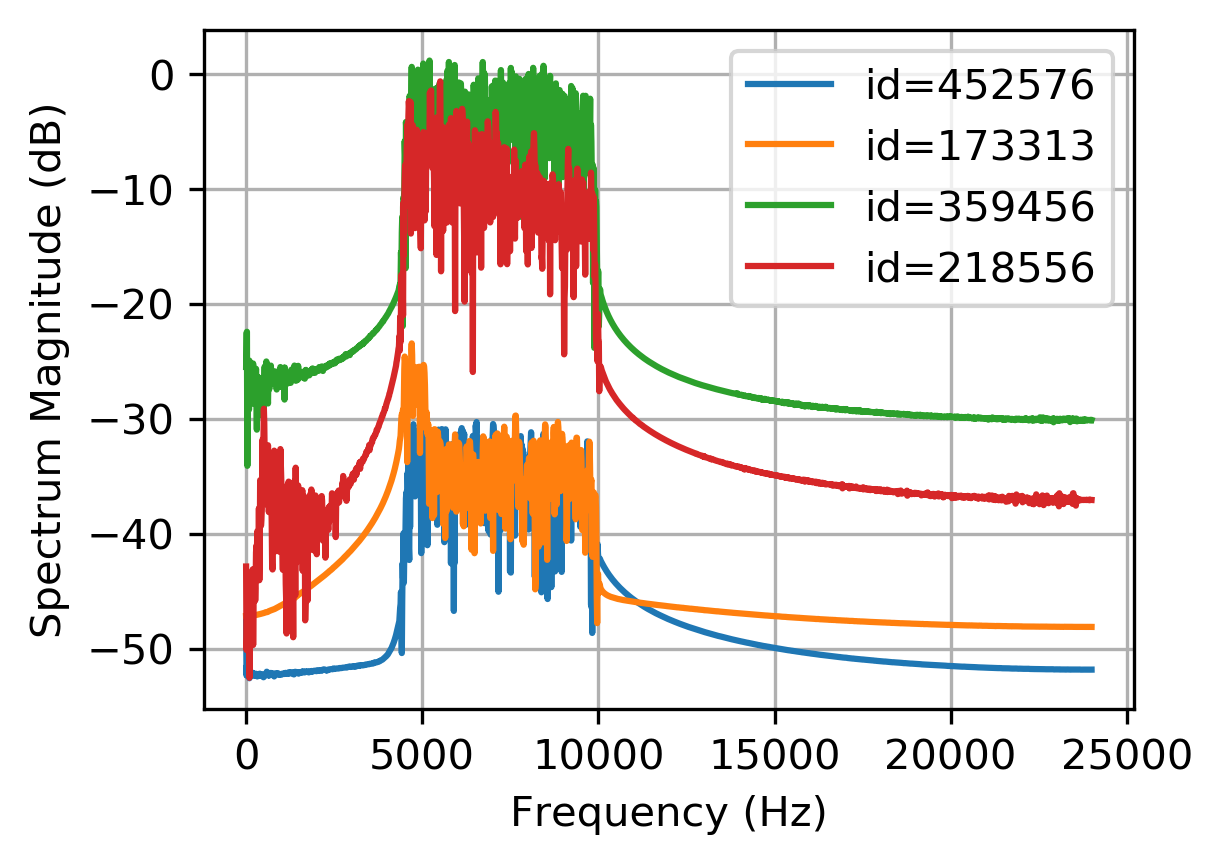

In [109]:
fig = plt.figure(figsize=(4, 3), dpi= 300, facecolor='w', edgecolor='k')

for row in spec:
    plt.plot(
        np.linspace(0,48000/2,int(Nfft/2)), 
        10*np.log10( np.array( row['mag'] ) )[:int(Nfft/2)],
        label='id=' + row['id']
    )

plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Magnitude (dB)')